# Training of an LSTM Model for Gold ETF price prediction and Rolex Prices

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Rah-Rah-Mitra/References/main/Recurrent%20Neural%20Networks/IAUF.csv')
df = df[['Date', 'Open', 'High', 'Low', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()


,Date,Open,High,Low,Close
0,2023-03-27,58.900002,58.900002,58.509998,58.720001
1,2023-03-28,58.990002,59.360001,58.950001,59.243000
2,2023-03-29,59.049999,59.049999,58.369999,58.369999
3,2023-03-30,59.099998,59.470001,59.099998,59.470001
4,2023-03-31,59.127998,59.127998,59.127998,59.127998


In [ ]:
df.tail()

,Date,Open,High,Low,Close
246,2024-03-19,56.584999,56.860001,56.584999,56.849998
247,2024-03-20,56.813000,57.404999,56.813000,57.404999
248,2024-03-21,57.930000,57.930000,56.990002,57.474998
249,2024-03-22,57.250000,57.250000,56.921001,56.921001
250,2024-03-25,57.340000,57.340000,55.000000,57.118999


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    251 non-null    datetime64[ns]
 1   Open    251 non-null    float64       
 2   High    251 non-null    float64       
 3   Low     251 non-null    float64       
 4   Close   251 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 9.9 KB


In [ ]:
D = df.iloc[:,1:2].values
test_size = 31
Tr_set = D[:-test_size] #train set
Ts_set = D[-test_size:] #test set
Tr_set.shape, Ts_set.shape

((220, 1), (31, 1))

In [ ]:
from tqdm.keras import TqdmCallback
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D, MaxPooling1D,Conv1D, Conv2D, BatchNormalization, LSTM, Normalization
from keras.models import Model, Sequential
tf.device('/device:GPU:0')

In [ ]:
sc = MinMaxScaler(feature_range=(0,1)) #scalar to scale data in between 0,1
Tr_scaled = sc.fit_transform(Tr_set) #scale data
Ts_scaled = sc.transform(Ts_set) #scale data (instead of embedding like we did for text)

## Create a Sliding Window for the LSTM to process the time series data

In [ ]:
seq_len = 5 #Create sequences of 100 or time steps of 100, so a sequence of 100 timesteps is associated with a single output
X_train = []
y_train = []
for i in range(seq_len,len(Tr_scaled)-seq_len):
    X_train.append(Tr_scaled[i-seq_len:i,0])
    y_train.append(Tr_scaled[i,0])
X_train,y_train = np.array(X_train),np.array(y_train)

In [ ]:
X_train[0]

array([0.69976928, 0.71016189, 0.71708995, 0.72286351, 0.72609677])

In [ ]:
X_train.shape

(210, 5)

In [ ]:
len(X_train[0])

5

In [ ]:
y_train[0]

0.7690531177829092

In [ ]:
X_test = []
y_test = []
for i in range(seq_len,len(Ts_scaled)-seq_len):
    X_test.append(Ts_scaled[i-seq_len:i,0])
    y_test.append(Ts_scaled[i,0])
X_test,y_test = np.array(X_test),np.array(y_test)

In [ ]:
X_train.shape #we have a total of 9800 sequences each with length 100

(210, 5)

In [ ]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #convert to 3d tensor

In [ ]:
X_train.shape #shape of whole data set

(210, 5, 1)

In [ ]:
X_train[0].shape #shape of input

(5, 1)

In [ ]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [ ]:
X_test.shape

(21, 5, 1)

## Creating model layers using the Tensorflow Library

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50,return_sequences=True,
              input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.1))
model.add(Normalization())
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(tf.keras.layers.GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

## Compile and Test the model

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.mse)

In [ ]:
model.fit(X_train, y_train, epochs=1000, batch_size=16, verbose=0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
result = model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 1s/step - loss: 0.0034


In [ ]:
y_hat = model.predict(X_test)

1/1 [==============================] - 1s 987ms/step


In [ ]:
y_hat.shape

(21, 1)

In [ ]:
MAPE = mean_absolute_percentage_error(y_test, y_hat)
Accuracy = 1 - MAPE

## Model Scores are not accurate for the IAUF data

In [ ]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.00338656990788877
Test MAPE: 0.2596045160951122
Test Accuracy: 0.7403954839048879


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             256       
                                                                 
 lstm (LSTM)                 (None, 3, 50)             23000     
                                                                 
 dropout (Dropout)           (None, 3, 50)             0         
                                                                 
 normalization (Normalizati  (None, 3, 50)             101       
 on)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 3, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 3, 50)             0         
                                                        

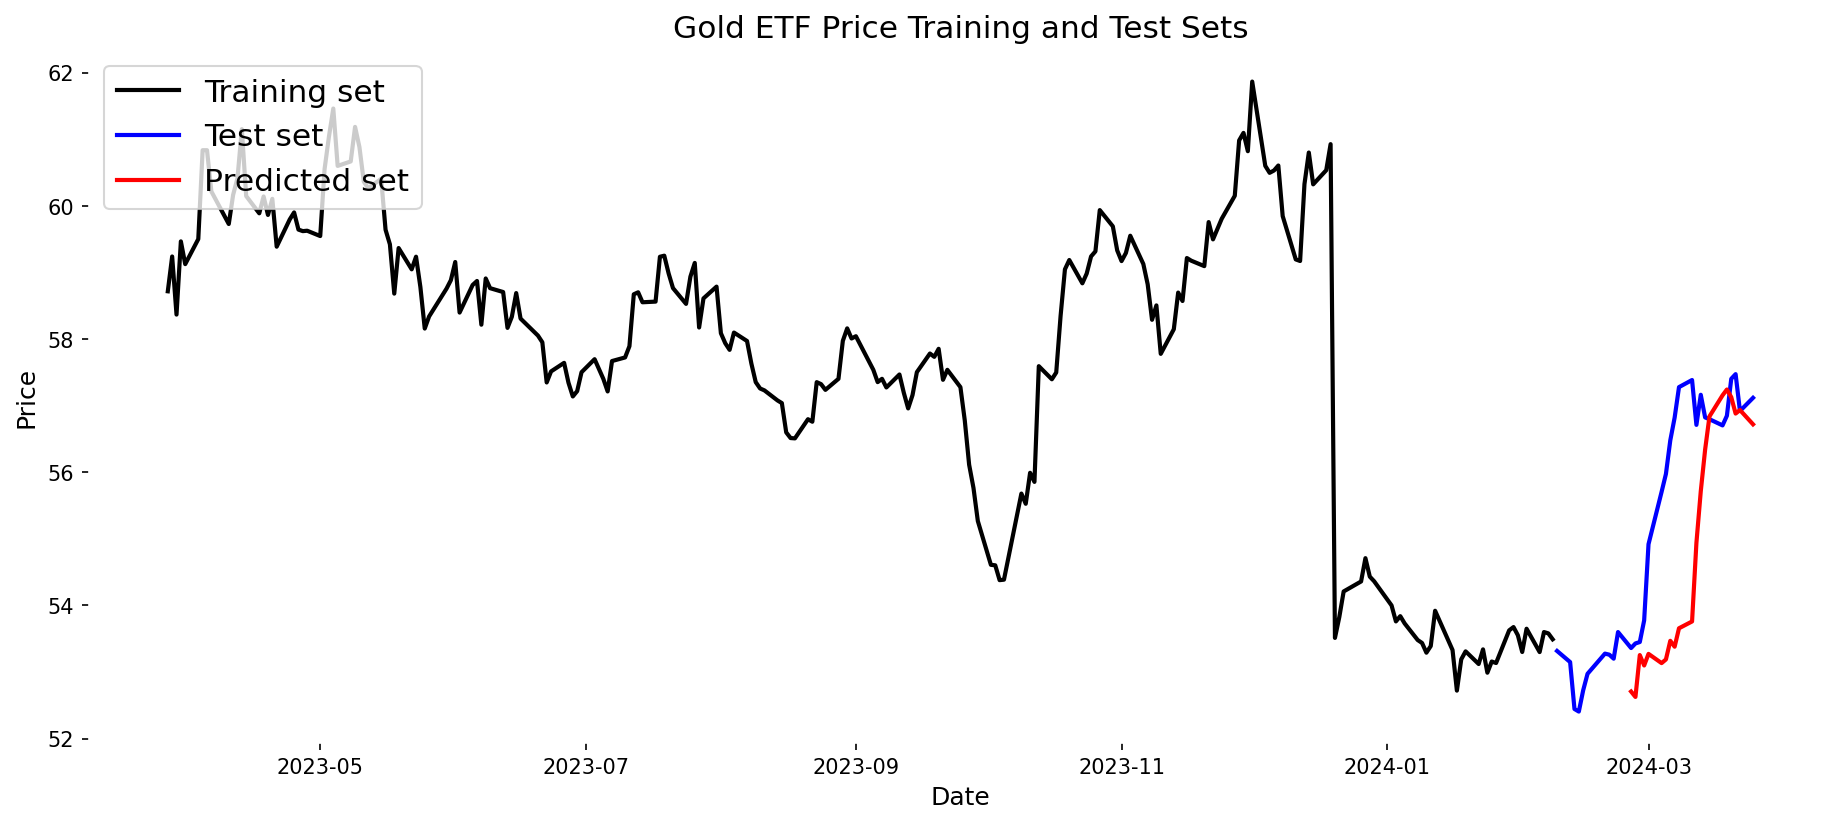

In [ ]:
# Reshape y_test and y_hat to 2D arrays if they are 1D
y_test_reshaped = y_test.reshape(-1, 1) if y_test.ndim == 1 else y_test
y_hat_reshaped = y_hat.reshape(-1, 1) if y_hat.ndim == 1 else y_hat

# Invert the scaling
y_test_inverted = sc.inverse_transform(y_test_reshaped)
y_hat_inverted = sc.inverse_transform(y_hat_reshaped)

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Close[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Close[-test_size:], color='blue', lw=2)
#plt.plot(df.Date[-len(y_test_inverted):], y_test_inverted, color='blue', lw=2)
plt.plot(df.Date[-len(y_hat_inverted):], y_hat_inverted, color='red', lw=2)
plt.title('Gold ETF Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set','Predicted set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

## The Model trained is not as accurate so let us use a pretrained model, a time series model called Chronos made by researchers, the model uses Transoformers to implement a Natural Language Process (NLP) Neural Network Architecture to capture the Time Series data.

# First we import the premade Pipeline for Chronos from the github repository, the Chronos model has 4 variation but we will use the chronos-t5-small model as out data size is limited and as seen from the Previous Model it is prone to overfitting.

In [ ]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-wfcgxlqq
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-wfcgxlqq
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 93bdda7f4bb6a4c65c48893cc13f77532f8d33b4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Rah-Rah-Mitra/References/main/Recurrent%20Neural%20Networks/RolexPrices.csv")

## Preprocess Data for the Rolex

In [ ]:
# Convert 'Date' to datetime if not already
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y')

# Calculate missing years
years = df['Date'].dt.year
missing = set(range(years.min(), years.max())) - set(years)

# Create a DataFrame for missing years
missing_df = pd.DataFrame({'Date': pd.to_datetime(list(missing), format='%Y')})

# Concatenate the original DataFrame with the DataFrame containing missing years
df = pd.concat([df, missing_df], ignore_index=True)

# Sort DataFrame by 'Date' and forward-fill missing values
df = df.sort_values('Date').ffill()

df.set_index('Date', inplace=True)

In [ ]:
rolex_model = "18K Submariner - 116619/126619LB White Gold"
df[rolex_model] = df[rolex_model].str.replace('[$,]', '', regex=True)
df[rolex_model] = pd.to_numeric(df[rolex_model], errors='coerce')
df[rolex_model] = df[rolex_model].fillna(method='bfill')

df[rolex_model].head()

Date
1973-08-01    18848.53
1974-01-01    18848.53
1975-03-01    18848.53
1976-01-01    18848.53
1977-07-01    18848.53
Name: 18K Submariner - 116619/126619LB White Gold, dtype: float64

## Predicting Rolex Submariner Time Series Data

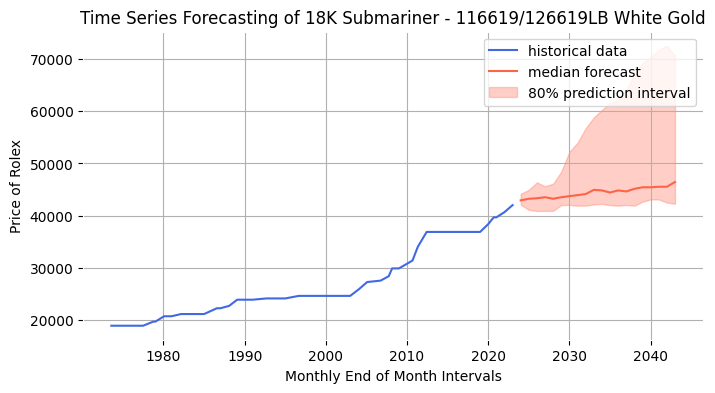

In [ ]:
# Convert the column to a tensor
context = torch.tensor(df[rolex_model].values)

prediction_length = 20 # Predict 20 years in the future
forecast = pipeline.predict(context, prediction_length, limit_prediction_length=False)

# Generate future dates for the forecast
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=prediction_length, freq='Y')

# Extract the median forecast values
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))

# Plot historical data
plt.plot(df.index, df[rolex_model], color="royalblue", label="historical data")

# Plot forecast data
plt.plot(forecast_dates, median, color="tomato", label="median forecast")

# Optionally, plot the prediction interval
low, high = np.quantile(forecast[0].numpy(), [0.1, 0.9], axis=0)
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% prediction interval")

plt.title(f"Time Series Forecasting of {rolex_model}")
plt.ylabel('Price of Rolex')
plt.xlabel('Monthly End of Month Intervals')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(f"Model: {rolex_model}")
print(f" Low:{low[-1]}")
print(f" Median:{median[-1]}")
print(f" High:{high[-1]}")

Model: 18K Submariner - 116619/126619LB White Gold
 Low:42252.591828069184
 Median:46423.70938960345
 High:70668.31252662375


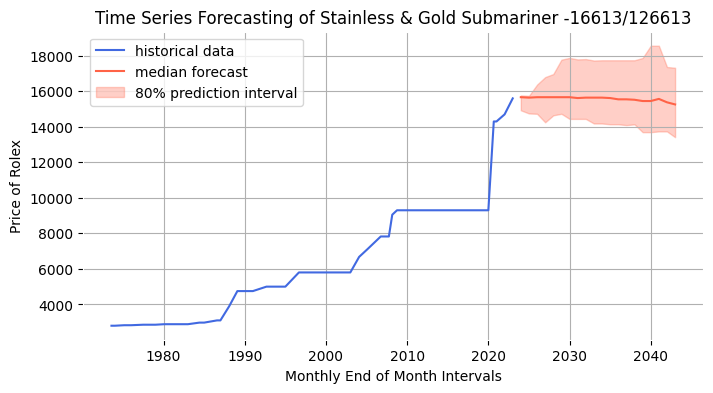

In [ ]:
rolex_model = "Stainless & Gold Submariner -16613/126613"
df[rolex_model] = df[rolex_model].str.replace('[$,]', '', regex=True)
df[rolex_model] = pd.to_numeric(df[rolex_model], errors='coerce')
df[rolex_model] = df[rolex_model].fillna(method='bfill')

# Convert the column to a tensor
context = torch.tensor(df[rolex_model].values)

prediction_length = 20 # Predict 20 years in the future
forecast = pipeline.predict(context, prediction_length, limit_prediction_length=False)

# Generate future dates for the forecast
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=prediction_length, freq='Y')

# Extract the median forecast values
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))

# Plot historical data
plt.plot(df.index, df[rolex_model], color="royalblue", label="historical data")

# Plot forecast data
plt.plot(forecast_dates, median, color="tomato", label="median forecast")

# Optionally, plot the prediction interval
low, high = np.quantile(forecast[0].numpy(), [0.1, 0.9], axis=0)
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% prediction interval")

plt.title(f"Time Series Forecasting of {rolex_model}")
plt.ylabel('Price of Rolex')
plt.xlabel('Monthly End of Month Intervals')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(f"Model: {rolex_model}")
print(f" Low:{low[-1]}")
print(f" Median:{median[-1]}")
print(f" High:{high[-1]}")

Model: Stainless & Gold Submariner -16613/126613
 Low:13414.583392169568
 Median:15259.088541403178
 High:17323.977408711824


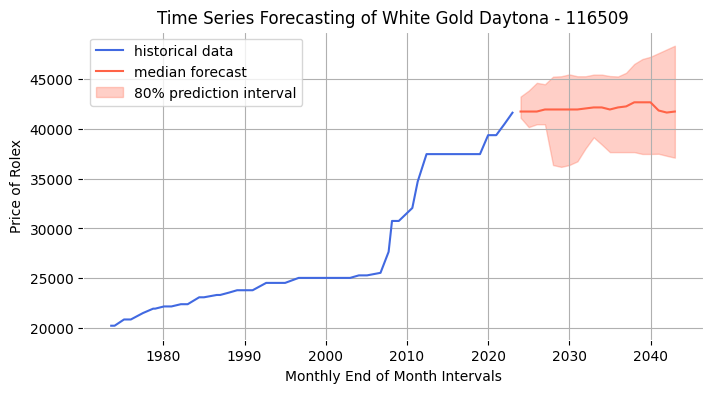

In [ ]:
rolex_model = "White Gold Daytona - 116509"
df[rolex_model] = df[rolex_model].str.replace('[$,]', '', regex=True)
df[rolex_model] = pd.to_numeric(df[rolex_model], errors='coerce')
df[rolex_model] = df[rolex_model].fillna(method='bfill')

# Convert the column to a tensor
context = torch.tensor(df[rolex_model].values)

prediction_length = 20 # Predict 20 years in the future
forecast = pipeline.predict(context, prediction_length, limit_prediction_length=False)

# Generate future dates for the forecast
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=prediction_length, freq='Y')

# Extract the low, median, high forecast values
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))

# Plot historical data
plt.plot(df.index, df[rolex_model], color="royalblue", label="historical data")

# Plot forecast data
plt.plot(forecast_dates, median, color="tomato", label="median forecast")

# Optionally, plot the prediction interval
low, high = np.quantile(forecast[0].numpy(), [0.1, 0.9], axis=0)
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% prediction interval")

plt.title(f"Time Series Forecasting of {rolex_model}")
plt.ylabel('Price of Rolex')
plt.xlabel('Monthly End of Month Intervals')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(f"Model: {rolex_model}")
print(f" Low:{low[-1]}")
print(f" Median:{median[-1]}")
print(f" High:{high[-1]}")

Model: White Gold Daytona - 116509
 Low:37094.76647943008
 Median:41718.76697656307
 High:48315.67645993491


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Rah-Rah-Mitra/References/main/Recurrent%20Neural%20Networks/IAUF.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-03-27,58.900002,58.900002,58.509998,58.720001,51.813068,11900
1,2023-03-28,58.990002,59.360001,58.950001,59.243000,52.274548,15600
2,2023-03-29,59.049999,59.049999,58.369999,58.369999,51.504234,4700
3,2023-03-30,59.099998,59.470001,59.099998,59.470001,52.474850,1100
4,2023-03-31,59.127998,59.127998,59.127998,59.127998,52.173073,400
...,...,...,...,...,...,...,...
246,2024-03-19,56.584999,56.860001,56.584999,56.849998,56.849998,7600
247,2024-03-20,56.813000,57.404999,56.813000,57.404999,57.404999,1200
248,2024-03-21,57.930000,57.930000,56.990002,57.474998,57.474998,3700
249,2024-03-22,57.250000,57.250000,56.921001,56.921001,56.921001,3000


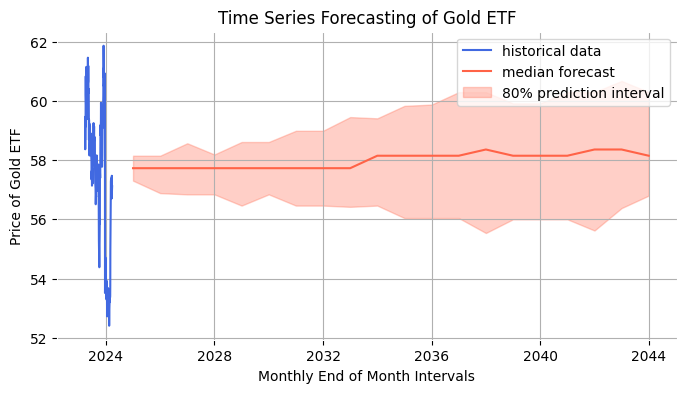

In [ ]:
# Convert the column to a tensor
context = torch.tensor(df['Close'].values)

prediction_length = 20 # Predict 20 years in the future
forecast = pipeline.predict(context, prediction_length, limit_prediction_length=False)

# Generate future dates for the forecast
last_date = df['Date'].iloc[-1]  # Using .iloc to access the last element
forecast_dates = pd.date_range(start=last_date, periods=prediction_length, freq='Y')

# Extract the low, median, high forecast values
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))

# Plot historical data
plt.plot(df['Date'], df['Close'], color="royalblue", label="historical data")

# Plot forecast data
plt.plot(forecast_dates, median, color="tomato", label="median forecast")

# Optionally, plot the prediction interval
low, high = np.quantile(forecast[0].numpy(), [0.1, 0.9], axis=0)
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% prediction interval")

plt.title("Time Series Forecasting of Gold ETF")
plt.ylabel('Price of Gold ETF')
plt.xlabel('Monthly End of Month Intervals')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(f"Gold ETF")
print(f" Low:{low[-1]}")
print(f" Median:{median[-1]}")
print(f" High:{high[-1]}")

Gold ETF
 Low:56.80359065688423
 Median:58.15204254630303
 High:60.301138430253204


## Special Thanks to the creators of Chronos and making of the pipeline to use the model easily

In [ ]:
'''
@article{ansari2024chronos,
  author  = {Ansari, Abdul Fatir and Stella, Lorenzo and Turkmen, Caner and Zhang, Xiyuan, and Mercado, Pedro and Shen, Huibin and Shchur, Oleksandr and Rangapuram, Syama Syndar and Pineda Arango, Sebastian and Kapoor, Shubham and Zschiegner, Jasper and Maddix, Danielle C. and Mahoney, Michael W. and Torkkola, Kari and Gordon Wilson, Andrew and Bohlke-Schneider, Michael and Wang, Yuyang},
  title   = {Chronos: Learning the Language of Time Series},
  journal = {arXiv preprint arXiv:2403.07815},
  year    = {2024}
}
'''

'\n@article{ansari2024chronos,\n  author  = {Ansari, Abdul Fatir and Stella, Lorenzo and Turkmen, Caner and Zhang, Xiyuan, and Mercado, Pedro and Shen, Huibin and Shchur, Oleksandr and Rangapuram, Syama Syndar and Pineda Arango, Sebastian and Kapoor, Shubham and Zschiegner, Jasper and Maddix, Danielle C. and Mahoney, Michael W. and Torkkola, Kari and Gordon Wilson, Andrew and Bohlke-Schneider, Michael and Wang, Yuyang},\n  title   = {Chronos: Learning the Language of Time Series},\n  journal = {arXiv preprint arXiv:2403.07815},\n  year    = {2024}\n}\n'